In [36]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [28]:
path="animals/animals"
data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      
print(data["labels"])
df = pd.DataFrame(data) 

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

['antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'antelope', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger', 'badger',

In [33]:
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                       imgpath        labels
0        animals/animals\coyote\140e11d384.jpg        coyote
1           animals/animals\owl\4ee4d30847.jpg           owl
2   animals/animals\caterpillar\89eeb3fb5a.jpg   caterpillar
3  animals/animals\hippopotamus\5bbec0931a.jpg  hippopotamus
4           animals/animals\bee\1cb123c4e9.jpg           bee
(3780, 3)
----------Test--------------
                                 imgpath  labels
0   animals/animals\bison\50ec617e59.jpg   bison
1   animals/animals\bison\2fe9812e0d.jpg   bison
2     animals/animals\cat\2d7dc1ddb5.jpg     cat
3   animals/animals\horse\169c1bbbea.jpg   horse
4  animals/animals\possum\0d16effd0b.jpg  possum
(1620, 3)


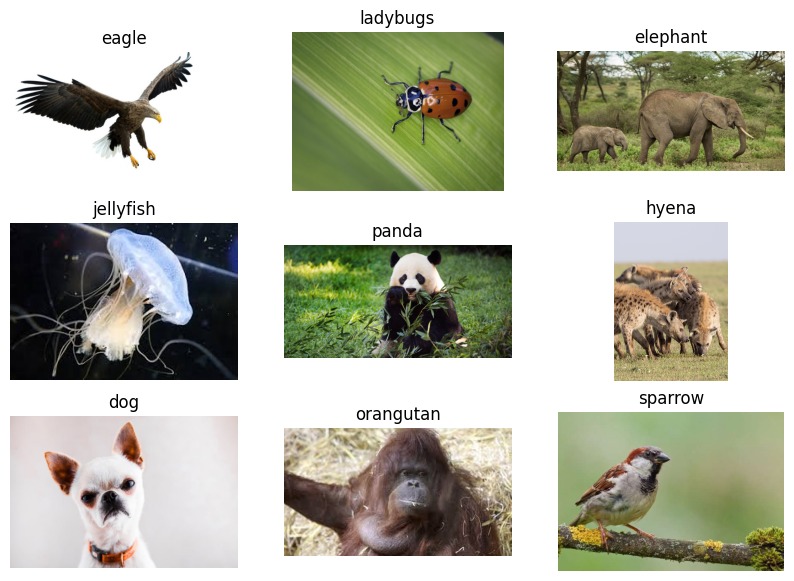

In [34]:
plt.figure(figsize=(10,7))
for i, row in test_df.sample(n=9).reset_index().iterrows():
    plt.subplot(3,3,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [35]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Split the data into 2 categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3780 validated image filenames belonging to 90 classes.
Found 1620 validated image filenames belonging to 90 classes.


## MODEL 1

In [37]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [38]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')         (X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [39]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

base_model = ResNet50(input_shape=(224, 224, 3))
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 10,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)